<a href="https://colab.research.google.com/github/nacczevedo/pos_datascience_analytics/blob/main/MVP_Modelo_B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Pós-Graduação em Ciências de Dados e Analytics

Sprint II

MVP - Modelo B

Aluna: Nathalia Azevedo


**Objetivos**

Você deverá treinar dois modelos de *machine learning*

**Modelo B:** utilizando *Deep Learning* para um problema de visão computacional ou processamento de linguagem natural.
Você deverá treinar um modelo baseado em *Deep Learning* para resolver um problema de visão computacional ou processamento de linguagem natural, iniciando na carga e preparação dos dados, incluindo a separação entre treino e teste, modelagem, otimização de hiperparâmetros, até a avaliação e comparação de resultados dos modelos treinados.




# **Checklist sugerido:**

**Definição do Problema**

*Objetivo*: entender e descrever claramente o problema que está sendo resolvido.

*   Qual é a descrição do problema?
*   Você tem premissas ou hipóteses sobre o problema? Quais?
*   Que restrições ou condições foram impostas para selecionar os dados?
*   Descreva o seu dataset (atributos, imagens, anotações, etc).

**Preparação de Dados**

*Objetivo*: realizar operações de preparação dos dados.


*   Separe o dataset entre treino e teste (e validação, se aplicável).
*   Faz sentido utilizar um método de validação cruzada? Justifique se não utilizar.
*   Verifique quais operações de transformação de dados (como normalização e padronização, transformação de imagens em tensores) são mais apropriadas para o seu problema e salve visões diferentes do seu dataset para posterior avaliação dos modelos.
*   Refine a quantidade de atributos disponíveis, realizando o processo de feature selection de forma adequada.

**Modelagem e treinamento:**

*Objetivo:* construir modelos para resolver o problema em questão.

*   Selecione os algoritmos mais indicados para o problema e dataset escolhidos, justificando as suas escolhas.
*   Há algum ajuste inicial para os hiperparâmetros?
*   O modelo foi devidamente treinado? Foi observado problema de underfitting?
*   É possível otimizar os hiperparâmetros de algum dos modelos? Se sim, faça-o, justificando todas as escolhas.
*   Há algum método avançado ou mais complexo que possa ser avaliado?
Posso criar um comitê de modelos diferentes para o problema (ensembles)?

**Avaliação de Resultados:**

*Objetivo*: analisar o desempenho dos modelos gerados em dados não vistos (com a base de teste)

*   Selecione as métricas de avaliação condizentes com o problema, justificando.
*   Treine o modelo escolhido com toda a base de treino, e teste-o com a base de teste.
*   Os resultados fazem sentido?
*   Foi observado algum problema de overfitting?
*   Compare os resultados de diferentes modelos.
*   Descreva a melhor solução encontrada, justificando.

Dataset from: https://www.kaggle.com/datasets/amytai/cancernet-bca?resource=download&select=CDIs_images_nifti

Contexto: Temos um conjunto de imagens que representam exames de imagem de mamas para diagnóstico de câncer de mama em duas categorias: verdadeiro ou falso para pCR. O objetivo deste notebook é criar um modelo de visão computacional que consiga classificar uma imagem em alguma das categorias mencionadas acima.
Logo, a partir do conjunto de imagens aprender a prever verdadeiro e falso para pCRs, onde pCR é a resposta patológica completa.
]


Cancer-Net BCa, um conjunto de dados de referência de acesso aberto de aquisição de dados de imagens de difusão correlacionadas (CDIs) sintéticas volumétricas de pacientes com câncer de mama. O Cancer-Net BCa faz parte da iniciativa global de código aberto e acesso aberto da Cancer-Net dedicada a acelerar o avanço no aprendizado de máquina para ajudar os médicos na luta global contra o câncer.

As aquisições de dados de CDIs volumétricos no conjunto de dados Cancer-Net BCa foram geradas a partir de uma coorte de pacientes pré-tratamento (T0) de 253 casos de pacientes do estudo American College of Radiology Imaging Network (ACRIN) 6698. Os pacientes desta coorte pré-tratamento não haviam recebido nenhuma quimioterapia neoadjuvante no momento da aquisição de imagens. O grau de Scarff-Bloom-Richardson (SBR) e a resposta patológica completa (pRC) do câncer de mama pós-tratamento à quimioterapia neoadjuvante são fornecidos como rótulos de saída para fins de treinamento e avaliação.

Este conjunto de dados está sendo usado para treinar e validar nossos modelos Cancer-Net BCa para predição de pCR a partir de aquisições de dados CDIs.


In [ ]:
# Examinando o metadata
# Esse arquivo inclui:

# ID do Paciente (key "patient_id")
# pCR status (key: "pCR")
# idade (key: "age")
# cor (if available, key: "race")
# Tipo de lesão (key: "lesion type")
# Subtipo genético (key: "HR/HER2")
# Grau Scarff-Bloom-Richardson (key: "SBR grade")
# Maior diâmetro (key: "MRLD")
# Sinalização para inclusão na coorte de análise ACRIN-6698 (key: "analysis cohort")

In [2]:
# Fazer import necessários

import os
import numpy as np
import pandas as pd
import nibabel as nib
from PIL import Image
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import keras
import tensorflow as tf
import cv2 as cv
import shutil
import random
import math
import zipfile
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import ResNet50,MobileNet, DenseNet201, InceptionV3, NASNetLarge, InceptionResNetV2, NASNetMobile
from keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.optimizers import Adam
from keras import layers
from keras import models
from keras import optimizers
from tensorflow.keras.preprocessing import image
from datetime import datetime
from tensorflow import keras
from sklearn.metrics import confusion_matrix, classification_report
import sklearn.metrics as skm
from google.colab import drive

## Acessar e tratar dados

In [3]:
# Diretório do arquivo csv dos dados
metadata_dir = ('/content/drive/MyDrive/cancerBca/metadata.csv')

# Lendo o arquivo csv
metadata = pd.read_csv(metadata_dir, sep=',')

In [4]:
#Percebe-se que devemos subtituir o Nan por Unknow
## Definir o intervalo de visualização (em escala log10)
display_range = (-5, 5)
metadata.replace(np.nan, 'Unknown', regex=True, inplace=True)

# código criar coluna target a partir da coluna pCR
# Quando coluna pCR é true, target = 1, se for False, target = 0
metadata['target'] = np.where(metadata['pCR'] == True, '1', '0')

In [5]:
metadata

,patient_id,pCR,age,race,lesion type,HR/HER2,SBR grade,MRLD,analysis cohort,target
0,ACRIN-6698-115987,False,42.0,Multiple Races,Multiple masses,HR - / HER2 - (TN),III (High),4.0,False,0
1,ACRIN-6698-860901,True,49.0,Unknown,Single mass,HR - / HER2 - (TN),III (High),4.6,True,1
2,ACRIN-6698-413211,False,66.0,White,Multiple masses,HR + / HER2 +,III (High),3.4,True,0
3,ACRIN-6698-801641,False,53.0,White,Multiple masses,HR - / HER2 - (TN),III (High),3.9,True,0
4,ACRIN-6698-408692,True,25.0,White,Multiple masses,HR - / HER2 - (TN),III (High),4.3,True,1
...,...,...,...,...,...,...,...,...,...,...
248,ACRIN-6698-417474,True,63.0,Asian,Multiple masses,HR - / HER2 - (TN),III (High),6.0,True,1
249,ACRIN-6698-490805,True,42.0,Unknown,Multiple masses,HR + / HER2 +,II (Intermediate),2.0,True,1
250,ACRIN-6698-736721,False,41.0,Unknown,Multiple masses,HR + / HER2 -,III (High),3.1,True,0
251,ACRIN-6698-220471,False,50.0,White,Multiple masses,HR - / HER2 +,III (High),3.4,True,0


False    171
True      82
Name: pCR, dtype: int64


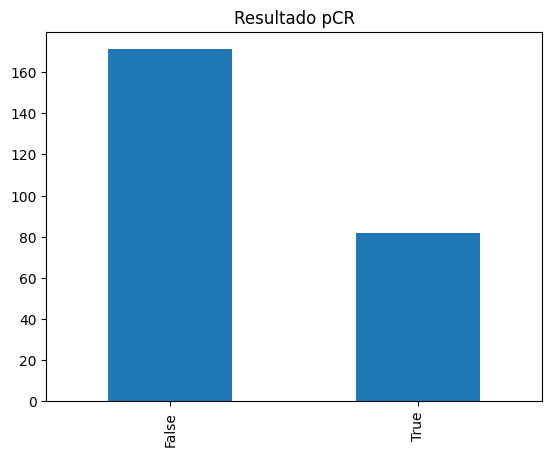

In [6]:
print((metadata['pCR']).value_counts())
pCR_count = metadata['pCR'].value_counts().plot.bar(title='Resultado pCR')

In [7]:
# Diretório das imagens
image_dir = ('/content/drive/MyDrive/cancerBca/CDIs_images_nifti')

# Definindo a lista de pacientes id
np.random.seed(28)
images = os.listdir(image_dir)

In [9]:
# Extração de características das imagens

heights = []
widths = []
channels = []
file_sizes = []

# Loop para iterar as imagens da pasta
for filename in images:
    # Pegando o patient_id
    patient_id = filename[:17]

    # Caminho da imagem
    image_path = os.path.join(image_dir, filename)

    # Abrindo a imagem usando PIL para pegar os atributos da imagem
    image = nib.load(image_path).get_fdata()

    # Convertendo imagens para 2D
    for plane in range(image.shape[2]):
      p = image[:,:,plane].astype(np.uint8)
      img = Image.fromarray(p)
      img.save(f'plane{plane}.png')

    # Pegando os atributos da imagem
    height, width = img.size
    channel = len(img.getbands())
    file_size = os.path.getsize(image_dir)

    # Criando uma lista com os valores dos atributos da imagem
    heights.append(height)
    widths.append(width)
    channels.append(channel)
    file_sizes.append(file_size)

# Criando o novo dataframe
img_info = pd.DataFrame({
    'patient_id': [filename[:17] for filename in images],
    'height': heights,
    'width': widths,
    'channel': channels,
    'filesize': file_sizes
})



In [10]:
img_info

,patient_id,height,width,channel,filesize
0,ACRIN-6698-107700,256,256,1,4096
1,ACRIN-6698-102212,256,256,1,4096
2,ACRIN-6698-104268,192,192,1,4096
3,ACRIN-6698-103939,256,256,1,4096
4,ACRIN-6698-118307,256,256,1,4096
...,...,...,...,...,...
248,ACRIN-6698-987728,256,256,1,4096
249,ACRIN-6698-991818,256,256,1,4096
250,ACRIN-6698-982086,256,256,1,4096
251,ACRIN-6698-995480,256,256,1,4096


In [11]:
metadata

,patient_id,pCR,age,race,lesion type,HR/HER2,SBR grade,MRLD,analysis cohort,target
0,ACRIN-6698-115987,False,42.0,Multiple Races,Multiple masses,HR - / HER2 - (TN),III (High),4.0,False,0
1,ACRIN-6698-860901,True,49.0,Unknown,Single mass,HR - / HER2 - (TN),III (High),4.6,True,1
2,ACRIN-6698-413211,False,66.0,White,Multiple masses,HR + / HER2 +,III (High),3.4,True,0
3,ACRIN-6698-801641,False,53.0,White,Multiple masses,HR - / HER2 - (TN),III (High),3.9,True,0
4,ACRIN-6698-408692,True,25.0,White,Multiple masses,HR - / HER2 - (TN),III (High),4.3,True,1
...,...,...,...,...,...,...,...,...,...,...
248,ACRIN-6698-417474,True,63.0,Asian,Multiple masses,HR - / HER2 - (TN),III (High),6.0,True,1
249,ACRIN-6698-490805,True,42.0,Unknown,Multiple masses,HR + / HER2 +,II (Intermediate),2.0,True,1
250,ACRIN-6698-736721,False,41.0,Unknown,Multiple masses,HR + / HER2 -,III (High),3.1,True,0
251,ACRIN-6698-220471,False,50.0,White,Multiple masses,HR - / HER2 +,III (High),3.4,True,0


In [12]:
# Merge do dataframe antigo com o novo usando o patient_id

merged_df = pd.merge(img_info,metadata, on='patient_id')

In [13]:
merged_df

,patient_id,height,width,channel,filesize,pCR,age,race,lesion type,HR/HER2,SBR grade,MRLD,analysis cohort,target
0,ACRIN-6698-107700,256,256,1,4096,False,68.0,Asian,Multiple masses,HR + / HER2 +,III (High),2.3,True,0
1,ACRIN-6698-102212,256,256,1,4096,False,26.0,White,Multiple masses,HR - / HER2 - (TN),III (High),7.4,True,0
2,ACRIN-6698-104268,192,192,1,4096,False,50.0,Black,Single mass,HR - / HER2 - (TN),III (High),3.5,True,0
3,ACRIN-6698-103939,256,256,1,4096,False,51.0,White,Multiple masses,HR + / HER2 -,III (High),4.5,True,0
4,ACRIN-6698-118307,256,256,1,4096,False,44.0,White,Multiple masses,HR - / HER2 - (TN),III (High),3.9,True,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
248,ACRIN-6698-987728,256,256,1,4096,True,56.0,Asian,Multiple masses,HR - / HER2 - (TN),III (High),3.5,True,1
249,ACRIN-6698-991818,256,256,1,4096,True,46.0,White,Single mass,HR + / HER2 +,III (High),2.5,True,1
250,ACRIN-6698-982086,256,256,1,4096,True,56.0,White,Multiple masses,HR - / HER2 +,III (High),2.0,True,1
251,ACRIN-6698-995480,256,256,1,4096,False,46.0,Asian,Multiple masses,HR + / HER2 +,III (High),4.6,True,0


0    171
1     82
Name: target, dtype: int64


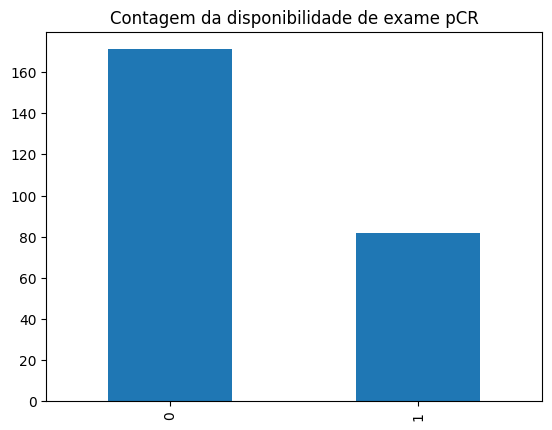

In [14]:
print((merged_df['target']).value_counts())
pCR_count = merged_df['target'].value_counts().plot.bar(title='Contagem da disponibilidade de exame pCR')

## Visualizando algumas imagens do conjunto de dados

In [ ]:
#  Selecionando imagens para visualizar
#ids = np.random.choice((patient_file_list), 6)
class_names = ('Sem pCR - 0', 'Com pCR - 1')

<ipython-input-27-d33416520e14>:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('jet').copy()


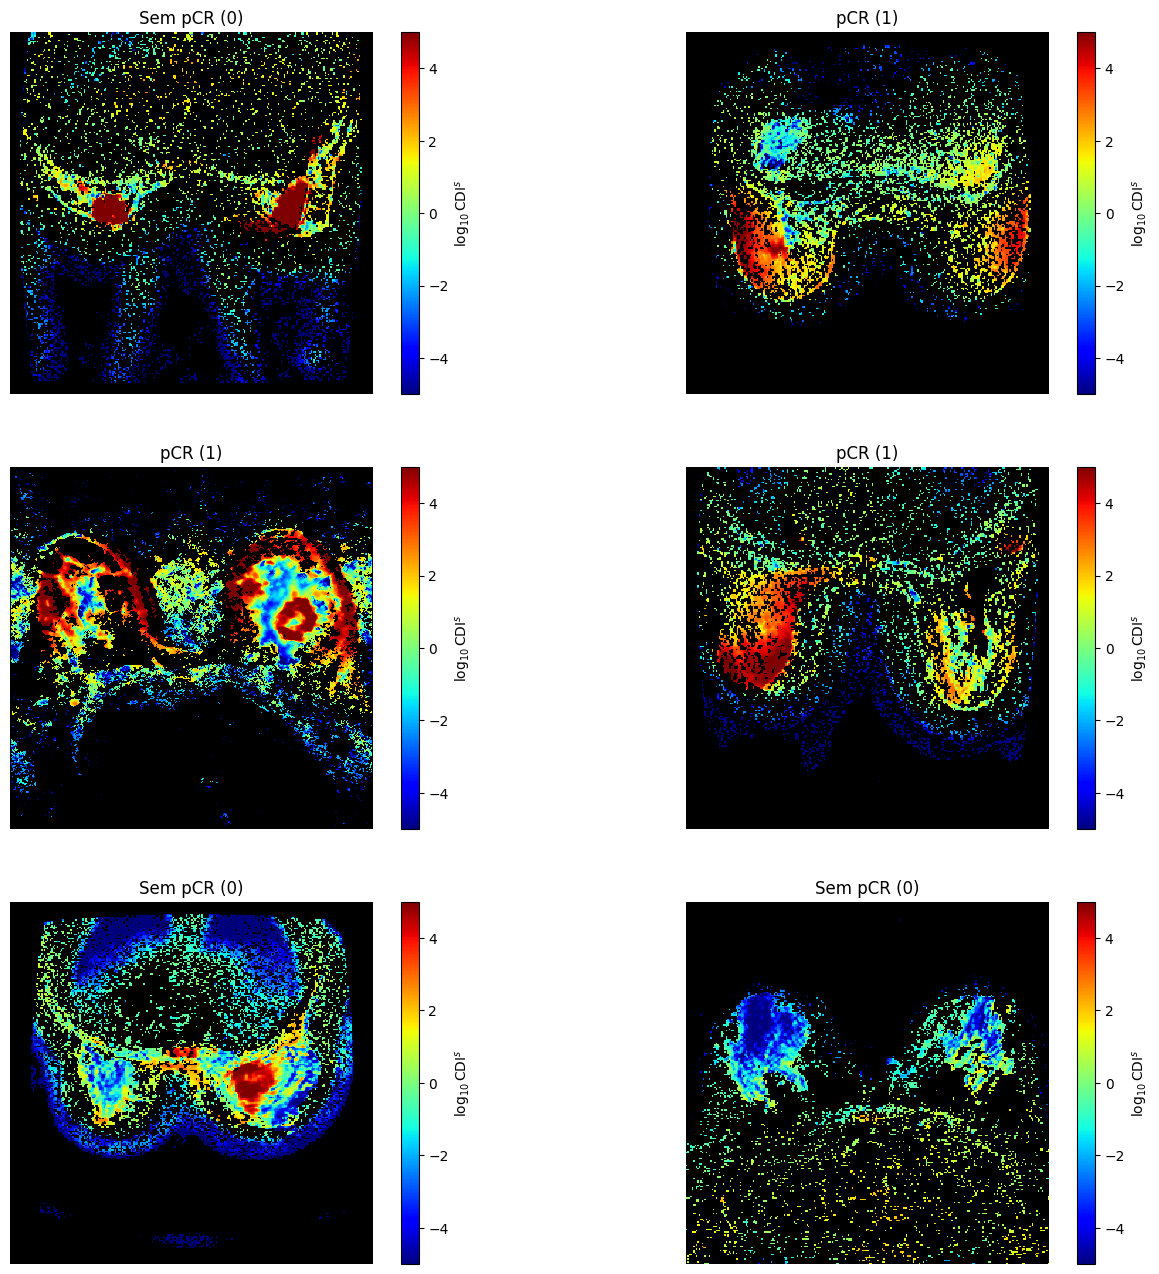

In [ ]:
# Mostrado um grid com 6 imagens
fig, axes = plt.subplots(3, 2, figsize=(16, 16))


for index, ax in zip(indices, axes.ravel()):
    # Carregando as imagens MRI
    cdis_file = os.path.join(image_dir, patient_file_list[index])
    cdis_volume = nib.load(cdis_file).get_fdata()

    # Pegar conjunto do meio
    cdis_display = cdis_volume[..., cdis_volume.shape[-1]//2]

    # Convertendo para a escala em log10
    valid = cdis_display > 0
    cdis_display[valid] = np.log10(cdis_display[valid])

    # Mascarar os inválidos
    cdis_display = np.ma.array(cdis_display, mask=~valid)

    # Pegar as classes
    patient_id = patient_file_list[index].split('_')[0]
    cls = int(metadata.loc[metadata['patient_id'] == patient_id]['pCR'].values[0])

    # Dividindo o display
    cmap = cm.get_cmap('jet').copy()
    cmap.set_bad('k')
    im = ax.imshow(
        cdis_display, interpolation='none', cmap=cmap,
        vmin=display_range[0], vmax=display_range[1]
    )
    plt.colorbar(im, ax=ax, label='$\log_{10}$CDI$^s$')
    ax.set_title('{} ({})'.format(class_names[cls], cls))
    ax.axis('off')
plt.show()

## Examinando o dataFrame
### Status do pCR, tipo de lesão, subtipo genético, grau SBR e cor

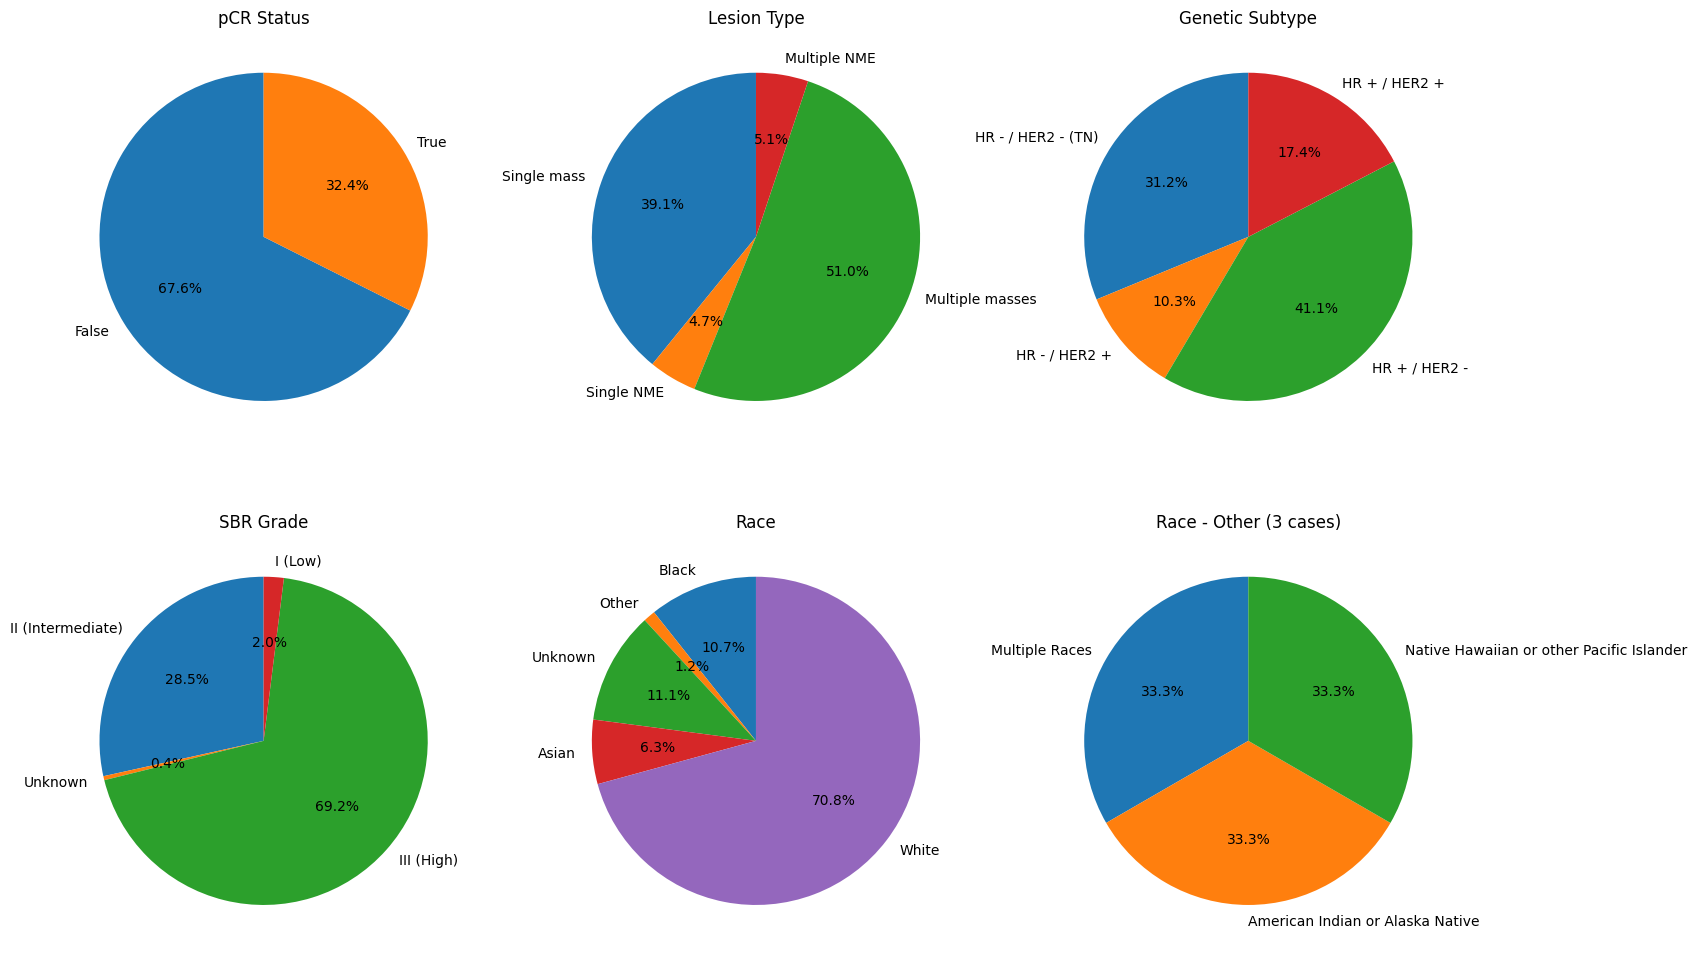

In [ ]:
# Obter dados para gráficos de pizza
pcr_labels, pcr_counts = np.unique(metadata['pCR'], return_counts=True)
race_labels, race_counts = np.unique(metadata['race'], return_counts=True)
type_labels, type_counts = np.unique(metadata['lesion type'], return_counts=True)
gen_labels, gen_counts = np.unique(metadata['HR/HER2'], return_counts=True)
sbr_labels, sbr_counts = np.unique(metadata['SBR grade'], return_counts=True)


# Exibir gráficos de pizza
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.ravel()
pie_chart(axes[0], pcr_counts, pcr_labels, title='pCR Status')
pie_chart(axes[1], type_counts, type_labels, title='Lesion Type')
pie_chart(axes[2], gen_counts, gen_labels, title='Genetic Subtype')
pie_chart(axes[3], sbr_counts, sbr_labels, title='SBR Grade')
subdivided_pie_chart(
    axes[4], axes[5], race_counts, race_labels,
    {'White', 'Black', 'Asian', 'Unknown'}, title='Race'
)

### Comparação entre idade e diâmetro da lesão

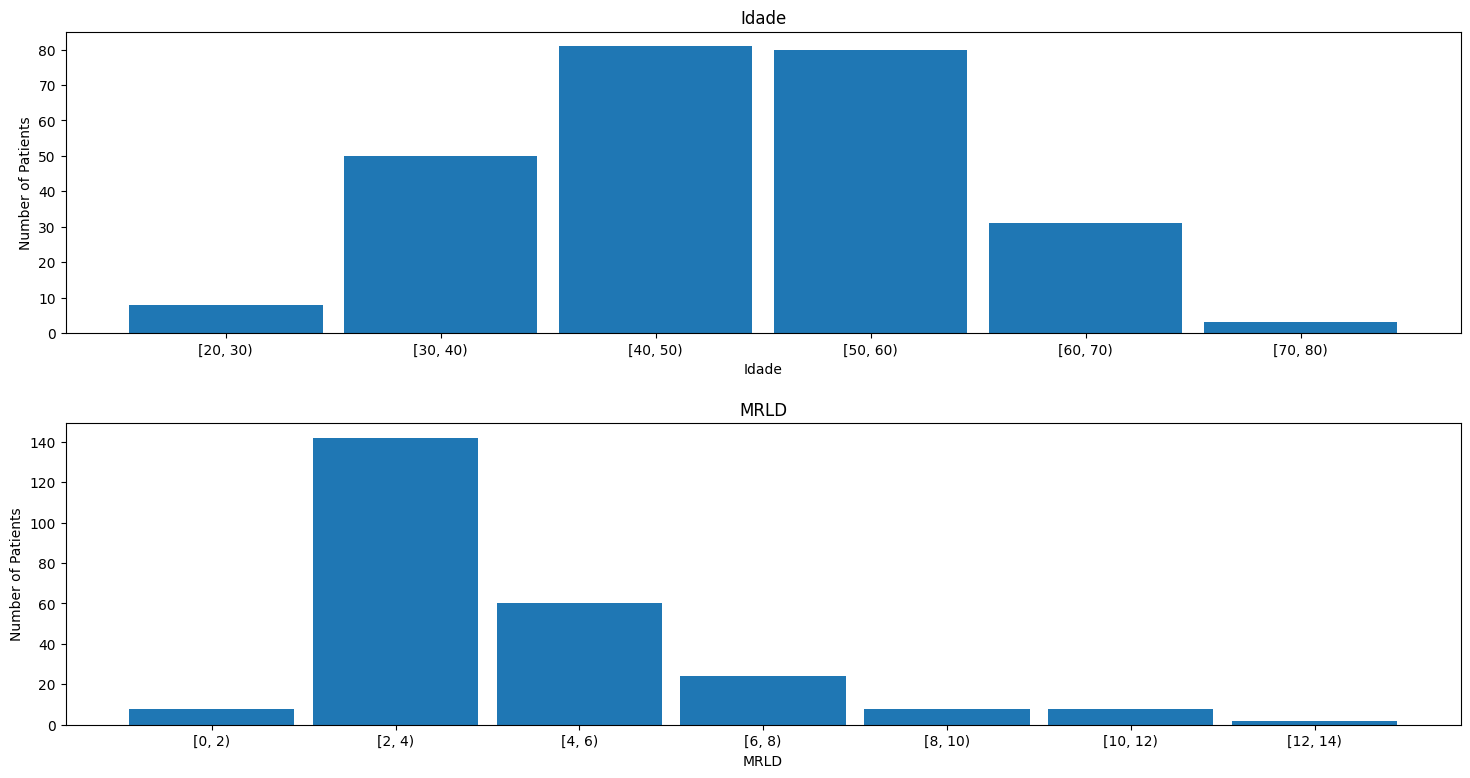

In [ ]:
def histogram(ax, data, bins, title=None):
    """Helper to plot a histogram"""
    labels = ['[{}, {})'.format(bins[i], bins[i+1]) for i in range(len(bins)-1)]
    ax.hist(data, bins, label=labels, rwidth=0.9)
    ax.set_xticks(bins[:-1] + (bins[1] - bins[0])/2)
    ax.set_xticklabels(labels)
    ax.set_ylabel('Number of Patients')
    ax.set_xlabel(title)
    if title is not None:
        ax.set_title(title)

# Fazer caixotes
age_bins = np.arange(20, 81, 10)
mrld_bins = np.arange(0, 15, 2)

# Exibir histogramas
fig, axes = plt.subplots(2, 1, figsize=(18, 9))
axes = axes.ravel()
histogram(axes[0], metadata['age'], age_bins, title='Idade')
histogram(axes[1], metadata['MRLD'], mrld_bins, title='MRLD')
plt.subplots_adjust(hspace=0.3)

## Divisão do dataset em treino e teste:

30% das imagens para teste e 70% para treinamento do modelo de deep learning. Importante lembrar que os conjuntos devem ser disjuntos, ou seja, não devem possuir nenhum elemento em comum.

In [16]:
train, test = train_test_split(merged_df[['patient_id' , 'target']] ,test_size=0.3 ,random_state=42 , shuffle=False)

In [17]:
print("##### Train: #####")
print(train)
print("##### Test: #####")
print(test)

##### Train: #####
            patient_id target
0    ACRIN-6698-107700      0
1    ACRIN-6698-102212      0
2    ACRIN-6698-104268      0
3    ACRIN-6698-103939      0
4    ACRIN-6698-118307      0
..                 ...    ...
172  ACRIN-6698-706639      0
173  ACRIN-6698-711476      1
174  ACRIN-6698-724293      1
175  ACRIN-6698-728149      0
176  ACRIN-6698-721099      0

[177 rows x 2 columns]
##### Test: #####
            patient_id target
177  ACRIN-6698-712785      0
178  ACRIN-6698-724384      0
179  ACRIN-6698-738041      1
180  ACRIN-6698-736721      0
181  ACRIN-6698-734997      0
..                 ...    ...
248  ACRIN-6698-987728      1
249  ACRIN-6698-991818      1
250  ACRIN-6698-982086      1
251  ACRIN-6698-995480      0
252  ACRIN-6698-992609      1

[76 rows x 2 columns]


### Preparação dos dados e criação do conjunto de validação

In [18]:
train_datagen=ImageDataGenerator(validation_split=0.2,
                                 rescale = 1.0/255,
                                 horizontal_flip=False)

test_datagen=ImageDataGenerator(rescale=1./255)


train_generator=train_datagen.flow_from_dataframe(
    train ,path,
    target_size=(150,150),
    batch_size=50,
    class_mode='binary',
    x_col='images',
    y_col='class',
    subset='training' #training set
    )

val_generator=train_datagen.flow_from_dataframe(
    train ,path,
    target_size=(150,150),
    batch_size=50,
    class_mode='binary',
    x_col='images',
    y_col='class',
    subset='validation' #validation set
    )

test_generator=test_datagen.flow_from_dataframe(
    test ,path,
    target_size=(150,150),
    batch_size=50,
    class_mode='binary',
    x_col='images',
    y_col='class',)

NameError: ignored

### Modelagem

In [ ]:
model=models.Sequential()
model.add(layers.Conv2D(32 ,(3,3) , activation='relu' , input_shape=(150,150,) ) )
model.add(layers.MaxPooling2D( (2,2)))

model.add(layers.Conv2D(64 , (3,3) , activation='relu'))
model.add(layers.MaxPooling2D( (2,2)))

model.add(layers.Conv2D(128 , (3,3) , activation='relu'))
model.add(layers.MaxPooling2D( (2,2)))

model.add(layers.Conv2D(128 , (3,3) , activation='relu'))
model.add(layers.MaxPooling2D( (2,2)))

In [ ]:
model.add(layers.Flatten() )
model.add(layers.Dropout(0.25))
model.add(layers.Dense(512 ,activation='relu' ))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(1 , activation='sigmoid' ) )

### Difinindo algumas funções

In [ ]:
def pie_chart(ax, data, labels, title=None):
    """Helper to plot a pie chart"""
    orig_data = np.asarray(data)
    orig_labels = np.asarray(labels)
    data = data.copy()
    labels = labels.copy()
    order = np.argsort(data)
    data[1::2] = orig_data[order[:len(data)//2]]
    data[::2] = orig_data[order[len(data)//2:]]
    labels[1::2] = orig_labels[order[:len(data)//2]]
    labels[::2] = orig_labels[order[len(data)//2:]]
    ax.pie(data, labels=labels, autopct='%1.1f%%', shadow=False, startangle=90)
    if title is not None:
        ax.set_title(title)

def subdivided_pie_chart(main_ax, sub_ax, data, labels, main_label_set, title=None):
    """Helper to create paired pie charts for limited-data categories"""
    main_labels, main_counts = [], []
    sub_labels, sub_counts = [], []
    for label, count in zip(labels, data):
        if label in main_label_set:
            main_labels.append(label)
            main_counts.append(count)
        else:
            sub_labels.append(label)
            sub_counts.append(count)
    main_labels.append('Other')
    main_counts.append(sum(sub_counts))
    sub_title = None
    if title is not None:
        sub_title = title + ' - Other ({} cases)'.format(main_counts[-1])
    pie_chart(main_ax, main_counts, main_labels, title=title)
    pie_chart(sub_ax, sub_counts, sub_labels, title=sub_title)

def histogram(ax, data, bins, title=None):
    """Helper to plot a histogram"""
    labels = ['[{}, {})'.format(bins[i], bins[i+1]) for i in range(len(bins)-1)]
    ax.hist(data, bins, label=labels, rwidth=0.9)
    ax.set_xticks(bins[:-1] + (bins[1] - bins[0])/2)
    ax.set_xticklabels(labels)
    ax.set_ylabel('Number of Patients')
    ax.set_xlabel(title)
    if title is not None:
        ax.set_title(title)

Visualização

In [ ]:
# Extrair métrica de treinamento e validação
loss = historico.history[‘loss’]
val_loss = historico.history[‘val_loss’]
accuracy = historico.history[‘accuracy’]
val_accuracy = historico.history[‘val_accuracy’]

# Plotando as curvas de perda e de precisão

plt.plot(loss, label=’Training Loss’)
plt.plot(val_loss, label=’Validation Loss’)
plt.xlabel(‘Epoch’)
plt.ylabel(‘Loss’)
plt.legend()
plt.show()

plt.plot(accuracy, label=’Training Accuracy’)
plt.plot(val_accuracy, label=’Validation Accuracy’)
plt.xlabel(‘Epoch’)
plt.ylabel(‘Accuracy’)
plt.legend()
plt.show()